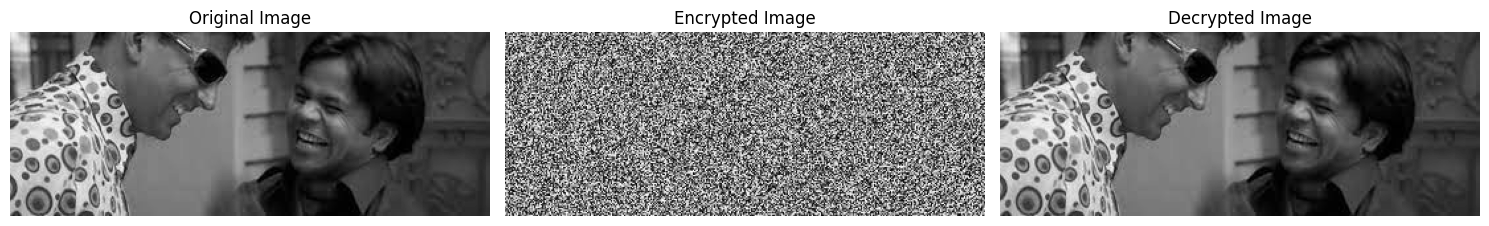

In [3]:
from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.hazmat.primitives import serialization
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Function to generate ECC private and public keys
def generate_ecc_keys():
    private_key = ec.generate_private_key(ec.SECP256R1(), default_backend())
    public_key = private_key.public_key()
    return private_key, public_key

# Function to serialize and save ECC private key to file
def save_private_key(private_key, filename):
    with open(filename, "wb") as key_file:
        key_file.write(private_key.private_bytes(
            encoding=serialization.Encoding.PEM,
            format=serialization.PrivateFormat.TraditionalOpenSSL,
            encryption_algorithm=serialization.NoEncryption()
        ))

# Function to load ECC private key from file
def load_private_key(filename):
    with open(filename, "rb") as key_file:
        private_key = serialization.load_pem_private_key(
            key_file.read(),
            password=None,
            backend=default_backend()
        )
    return private_key

# Function to derive symmetric encryption key from ECC public key
def derive_symmetric_key(public_key):
    peer_key_bytes = public_key.public_bytes(
        encoding=serialization.Encoding.PEM,
        format=serialization.PublicFormat.SubjectPublicKeyInfo
    )
    kdf = HKDF(
        algorithm=hashes.SHA256(),
        length=32,
        salt=None,
        info=b'handshake data',
        backend=default_backend()
    )
    return kdf.derive(peer_key_bytes)

# Function to encrypt image using symmetric encryption (AES)
def encrypt_image(image, symmetric_key):
    iv = os.urandom(16)
    cipher = Cipher(algorithms.AES(symmetric_key), modes.CFB(iv), backend=default_backend())
    encryptor = cipher.encryptor()
    encrypted_image = encryptor.update(image) + encryptor.finalize()
    return encrypted_image, iv

# Function to decrypt image using symmetric encryption (AES)
def decrypt_image(encrypted_image, iv, symmetric_key):
    cipher = Cipher(algorithms.AES(symmetric_key), modes.CFB(iv), backend=default_backend())
    decryptor = cipher.decryptor()
    decrypted_image = decryptor.update(encrypted_image) + decryptor.finalize()
    return decrypted_image

# Load an image
image_path = 'image.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Generate ECC keys
private_key, public_key = generate_ecc_keys()

# Save ECC private key to file
private_key_file = 'private_key.pem'
save_private_key(private_key, private_key_file)

# Load ECC private key from file
loaded_private_key = load_private_key(private_key_file)

# Derive symmetric encryption key from ECC public key
symmetric_key = derive_symmetric_key(public_key)

# Encrypt the image
encrypted_image, iv = encrypt_image(image.tobytes(), symmetric_key)

# Decrypt the image
decrypted_image = decrypt_image(encrypted_image, iv, symmetric_key)

# Display the images
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(np.frombuffer(encrypted_image, dtype=np.uint8).reshape(image.shape), cmap='gray')
plt.title('Encrypted Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(np.frombuffer(decrypted_image, dtype=np.uint8).reshape(image.shape), cmap='gray')
plt.title('Decrypted Image')
plt.axis('off')

plt.tight_layout()
plt.show()
